<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Anomalies Removal with the Isolation Forest  (IF)
</p>

In [1]:
# === Imports & Config ===
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler  # For standardizing features

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")
%matplotlib inline

DATA_PATH = Path("../LoRaWAN Localization - Advanced Files/all3_gateways_visually_cleaned_df.csv")
OUTPUT_PATH = Path("../LoRaWAN Localization - Advanced Files/all3_gateways_cleaned_dataset_per_device.csv")

In [2]:
# === Load the data===
data = pd.read_csv(DATA_PATH)
print(f"Loaded {len(data):,} rows, {data.shape[1]} cols")
display(data)

Loaded 4,595,033 rows, 21 cols


,time,gateway,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,c_walls_gw0,w_walls_gw0,distance_gw0,exp_pl_gw0,n_power,esp
0,2024-10-01 00:00:25.147365+00:00,GW1,ED0,446.0,42.71,0.47,313.25,20.74,-50.0,12.5,11,867.9,5892.0,6638.0,0.987136,NaN,NaN,NaN,NaN,-62.737602,-50.237602
1,2024-10-01 00:22:27.032554+00:00,GW1,ED0,460.0,42.72,0.33,313.40,20.72,-120.0,-18.8,12,867.7,5914.0,6660.0,1.810432,NaN,NaN,NaN,NaN,-120.056877,-138.856877
2,2024-10-01 00:23:27.078821+00:00,GW1,ED0,458.0,42.69,0.57,313.39,20.74,-118.0,-18.5,12,868.3,5915.0,6661.0,1.810432,NaN,NaN,NaN,NaN,-118.060916,-136.560916
3,2024-10-01 00:25:28.129948+00:00,GW1,ED0,459.0,42.73,0.52,313.36,20.74,-120.0,-22.5,12,867.9,5916.0,6662.0,1.810432,NaN,NaN,NaN,NaN,-120.024354,-142.524354
4,2024-10-01 00:33:26.135224+00:00,GW1,ED0,452.0,42.74,0.34,313.48,20.73,-119.0,-17.8,10,867.3,5923.0,6671.0,0.452608,NaN,NaN,NaN,NaN,-119.071483,-136.871483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595028,2025-09-30 23:55:54.424694+00:00,GW0,ED5,487.0,46.39,2.80,331.89,22.50,-96.0,12.5,9,868.3,127143.0,127510.0,0.246784,2.0,2.0,40.0,113.26,-108.737602,-96.237602
4595029,2025-09-30 23:56:54.475849+00:00,GW0,ED5,492.0,46.32,2.87,331.88,22.51,-96.0,11.5,9,868.1,127144.0,127511.0,0.246784,2.0,2.0,40.0,113.26,-107.797062,-96.297062
4595030,2025-09-30 23:57:54.522181+00:00,GW0,ED5,495.0,46.33,2.84,331.87,22.50,-96.0,11.8,9,867.7,127145.0,127512.0,0.246784,2.0,2.0,40.0,113.26,-108.077855,-96.277855
4595031,2025-09-30 23:58:54.575768+00:00,GW0,ED5,495.0,46.35,3.07,331.91,22.49,-98.0,11.5,9,867.1,127146.0,127513.0,0.246784,2.0,2.0,40.0,115.26,-109.797062,-98.297062


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Clean (time parse, drop SF11/12, numeric casting, NaN/Inf/zero removal)
</p>

In [3]:
df = data.copy()
df["time"] = pd.to_datetime(df["time"], format="ISO8601", errors="coerce", utc=True)

rows0 = len(df)
df = df[~df["SF"].isin([11, 12])]
rows_after_sf = len(df)

# Only convert intended numeric columns
numeric_cols = [
    "SF", "co2", "humidity", "pm25", "pressure", "temperature",
    "rssi", "snr"
]
numeric_cols = [c for c in numeric_cols if c in df.columns]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop NaN/Inf only on these numeric columns
before_nan = len(df)
nan_mask = df[numeric_cols].isnull().any(axis=1) | df[numeric_cols].isin([np.inf, -np.inf]).any(axis=1)
df = df[~nan_mask].reset_index(drop=True)

# Drop rows with zeros in selected cols (optional)
zero_cols = [c for c in ["co2", "humidity", "pressure", "temperature"] if c in df.columns]
before_zero = len(df)
if zero_cols:
    df = df[~(df[zero_cols] == 0).any(axis=1)].reset_index(drop=True)

print(f"Start: {rows0:,}")
print(f"After SF filter: {rows_after_sf:,} (removed {rows0 - rows_after_sf:,})")
print(f"After NaN/Inf on numeric cols: {len(df):,} (removed {before_nan - len(df):,})")
print(f"After zero filter: {len(df):,} (removed {before_zero - len(df):,})")

Start: 4,595,033
After SF filter: 3,448,545 (removed 1,146,488)
After NaN/Inf on numeric cols: 3,446,288 (removed 2,257)
After zero filter: 3,446,288 (removed 0)


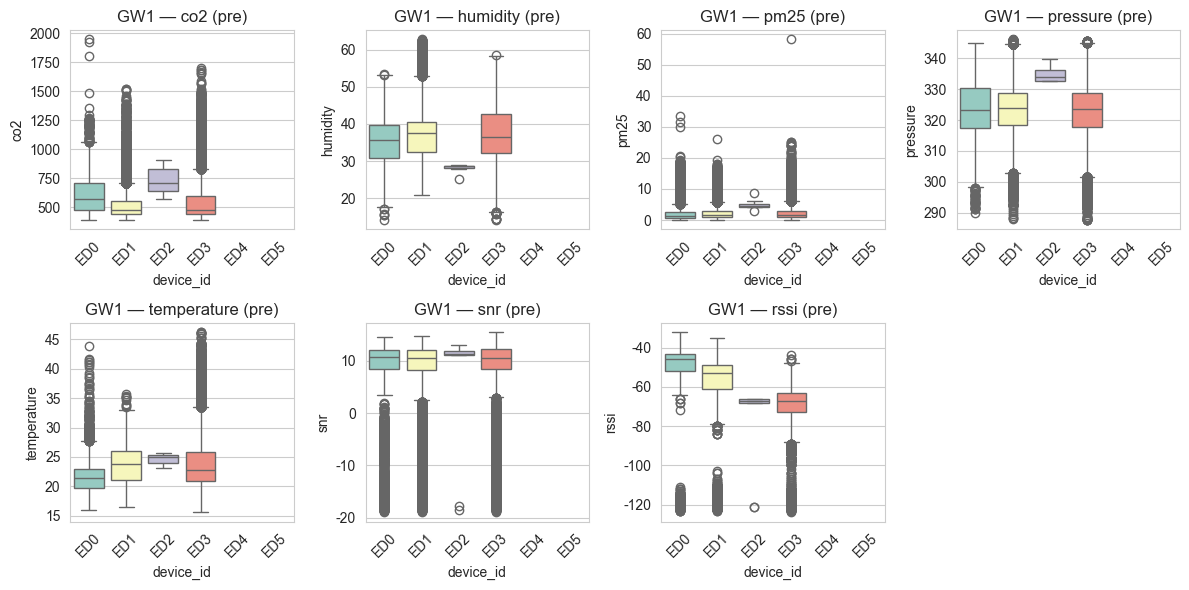

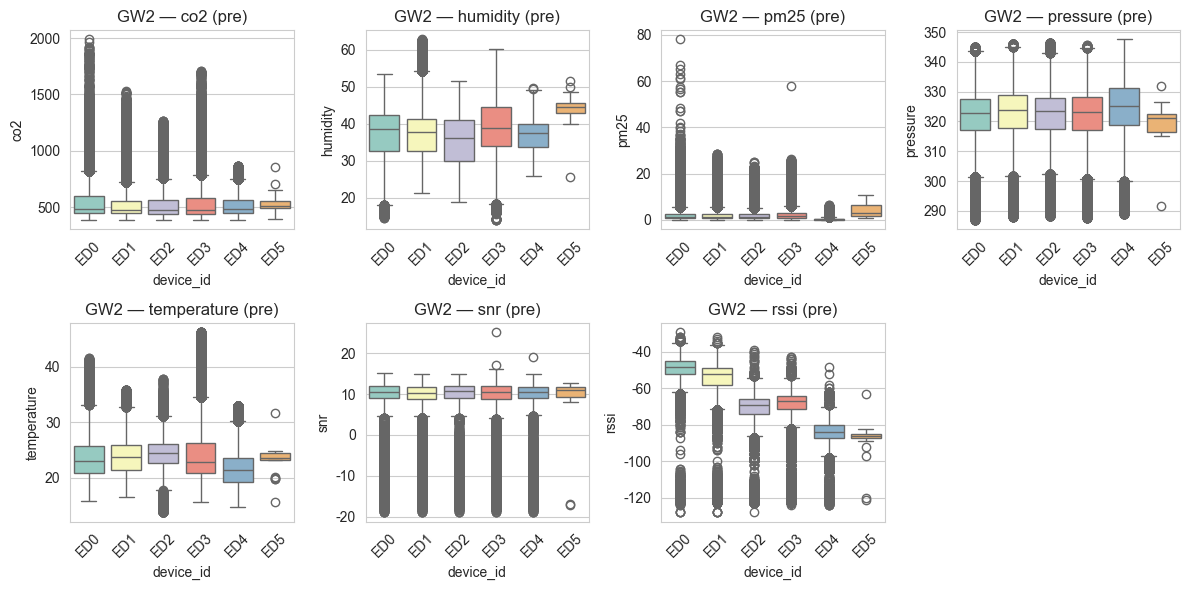

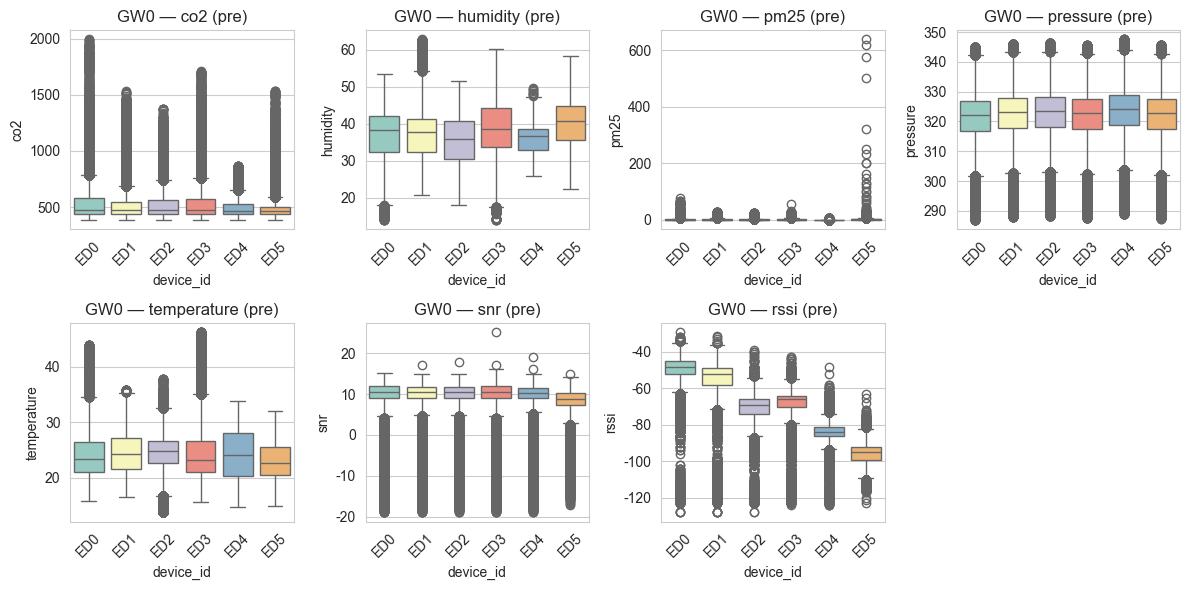

In [4]:
plot_cols = ['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'snr', 'rssi']
plot_cols = [c for c in plot_cols if c in df.columns]
order = [d for d in ["ED0","ED1","ED2","ED3","ED4","ED5"] if d in df["device_id"].unique()]
df["device_id"] = pd.Categorical(df["device_id"], categories=order, ordered=True)

for gw in df["gateway"].unique():
    gdf = df[df["gateway"] == gw]
    cols = 4
    rows = math.ceil(len(plot_cols) / cols)
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, col in enumerate(plot_cols, 1):
        plt.subplot(rows, cols, i)
        ax = sns.boxplot(
            data=gdf, x="device_id", y=col,
            hue="device_id", order=order, palette="Set3", dodge=False
        )
        if ax.get_legend():
            ax.get_legend().remove()
        plt.title(f"{gw} — {col} (pre)")
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Feature engineering (temporal stats, diffs)
</p>

In [5]:
# === Feature Engineering ===
base_feats = ['co2','humidity','pm25','pressure','temperature','rssi','snr']
base_feats = [c for c in base_feats if c in df.columns]

def add_features(frame: pd.DataFrame) -> pd.DataFrame:
    frame = frame.sort_values("time").reset_index(drop=True)
    for f in base_feats:
        frame[f] = pd.to_numeric(frame[f], errors="coerce")
    # only require the base features to be present
    frame = frame.dropna(subset=base_feats)

    for f in base_feats:
        frame[f + f"_mean{WINDOW}"] = frame[f].rolling(window=WINDOW, min_periods=1).mean()
        frame[f + "_diff"] = frame[f].diff().fillna(0)

    # only drop rows missing the model features (base + engineered)
    feat_cols = [c for c in frame.columns if any(c.startswith(b) for b in base_feats)]
    return frame.dropna(subset=feat_cols)

def robust_z(series: pd.Series) -> pd.Series:
    med = series.median()
    mad = (series - med).abs().median()
    if mad == 0:
        return pd.Series(np.zeros(len(series)), index=series.index)
    return 0.6745 * (series - med) / mad

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Model-based anomalies (Isolation Forest)
</p>

In [6]:
# === Model-based Anomalies per Gateway & Device  ===
features = ['co2','humidity','pm25','pressure','temperature','rssi','snr']
contamination_level = 0.01
window_size = 8

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

def detect_anomalies_per_group(device_data, contamination=contamination_level):
    device_data = device_data.sort_values('time').reset_index(drop=True)
    for col in features:
        if col in device_data:
            device_data[col] = pd.to_numeric(device_data[col], errors='coerce')

    # require core signal columns
    device_data = device_data.dropna(subset=['rssi','snr'])
    if device_data.empty:
        return pd.DataFrame(), {}

    for f in features:
        if f in device_data:
            device_data[f + '_mean' + str(window_size)] = device_data[f].rolling(window=window_size, min_periods=1).mean()
            device_data[f + '_diff'] = device_data[f].diff()
    engineered = [c for c in device_data.columns if any(c.startswith(b) for b in features)]
    device_data = device_data.dropna(subset=engineered)
    if device_data.empty:
        return pd.DataFrame(), {}

    X = device_data[engineered]
    X_scaled = StandardScaler().fit_transform(X)

    iso = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    ).fit(X_scaled)
    device_data['anomaly_score'] = iso.decision_function(X_scaled)
    device_data['anomaly'] = iso.predict(X_scaled)  # 1 normal, -1 anomaly
    device_data['anomaly_label'] = device_data['anomaly'].map({1:'Normal', -1:'Anomaly'})

    stats = {
        'gateway': device_data['gateway'].iloc[0] if 'gateway' in device_data else None,
        'device_id': device_data['device_id'].iloc[0],
        'total_points': len(device_data),
        'anomalies_detected': (device_data['anomaly']==-1).sum(),
        'anomaly_percentage': (device_data['anomaly']==-1).mean()*100
    }
    return device_data, stats

group_cols = ['gateway','device_id'] if 'gateway' in df.columns else ['device_id']
results, device_stats = [], []

for keys, device_data in df.groupby(group_cols, observed=True):
    gw, dev = keys if isinstance(keys, tuple) else (None, keys)
    print(f"Processing: gateway={gw}, device={dev}")
    device_analyzed, stats = detect_anomalies_per_group(device_data, contamination=contamination_level)
    if device_analyzed.empty:
        print(f"  -> Empty after preprocessing: gateway={gw}, device={dev}")
        continue
    results.append(device_analyzed); device_stats.append(stats)

if results:
    data_with_anomalies = pd.concat(results, ignore_index=True)
    anomalies = data_with_anomalies[data_with_anomalies['anomaly'] == -1]
    cleaned_data = data_with_anomalies[data_with_anomalies['anomaly'] == 1]
    stats_df = pd.DataFrame(device_stats)
    total_points_all = stats_df['total_points'].sum()
    anomalies_detected_all = stats_df['anomalies_detected'].sum()
    anomaly_percentage_all = anomalies_detected_all / total_points_all * 100
    print(f"Total data points processed: {total_points_all}")
    print(f"Total anomalies detected: {anomalies_detected_all}")
    print(f"Overall anomaly percentage: {anomaly_percentage_all:.2f}%")
    display(stats_df)
else:
    print("No valid data was processed for any group.")

Processing: gateway=GW0, device=ED0
Processing: gateway=GW0, device=ED1
Processing: gateway=GW0, device=ED2
Processing: gateway=GW0, device=ED3
Processing: gateway=GW0, device=ED4
Processing: gateway=GW0, device=ED5
Processing: gateway=GW1, device=ED0
Processing: gateway=GW1, device=ED1
Processing: gateway=GW1, device=ED2
Processing: gateway=GW1, device=ED3
Processing: gateway=GW2, device=ED0
Processing: gateway=GW2, device=ED1
Processing: gateway=GW2, device=ED2
Processing: gateway=GW2, device=ED3
Processing: gateway=GW2, device=ED4
Processing: gateway=GW2, device=ED5
Total data points processed: 3446272
Total anomalies detected: 34472
Overall anomaly percentage: 1.00%


,gateway,device_id,total_points,anomalies_detected,anomaly_percentage
0,GW0,ED0,350663,3507,1.000106
1,GW0,ED1,347038,3471,1.000179
2,GW0,ED2,351803,3519,1.000276
3,GW0,ED3,344925,3450,1.000217
4,GW0,ED4,347369,3474,1.000089
5,GW0,ED5,358757,3588,1.000120
6,GW1,ED0,7318,74,1.011205
7,GW1,ED1,42176,422,1.000569
8,GW1,ED2,13,1,7.692308
9,GW1,ED3,73066,731,1.000465


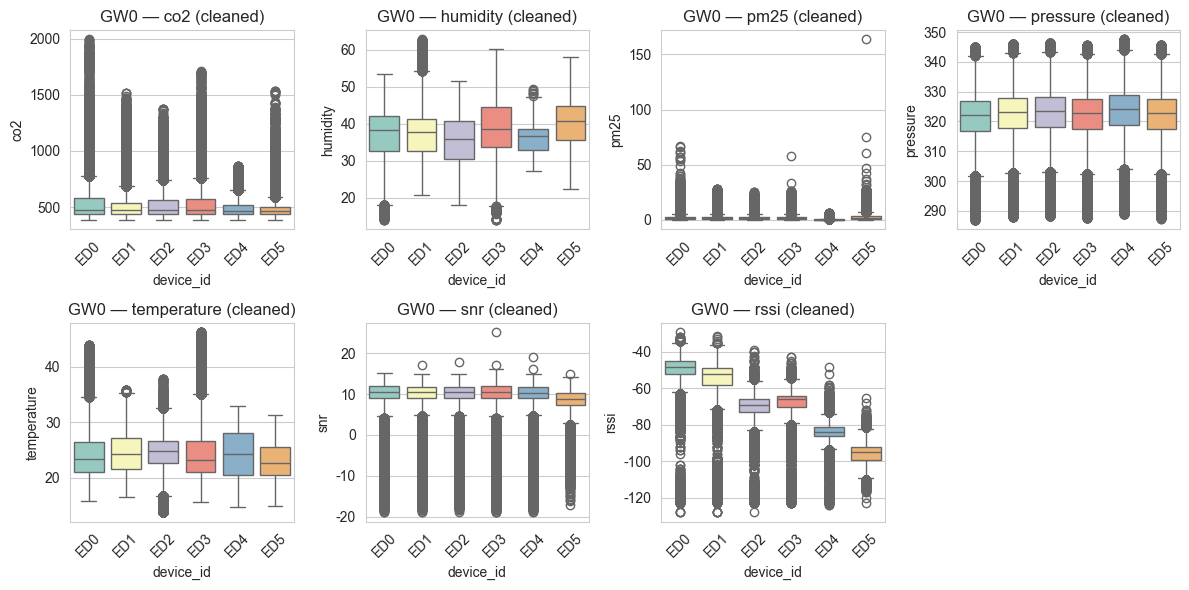

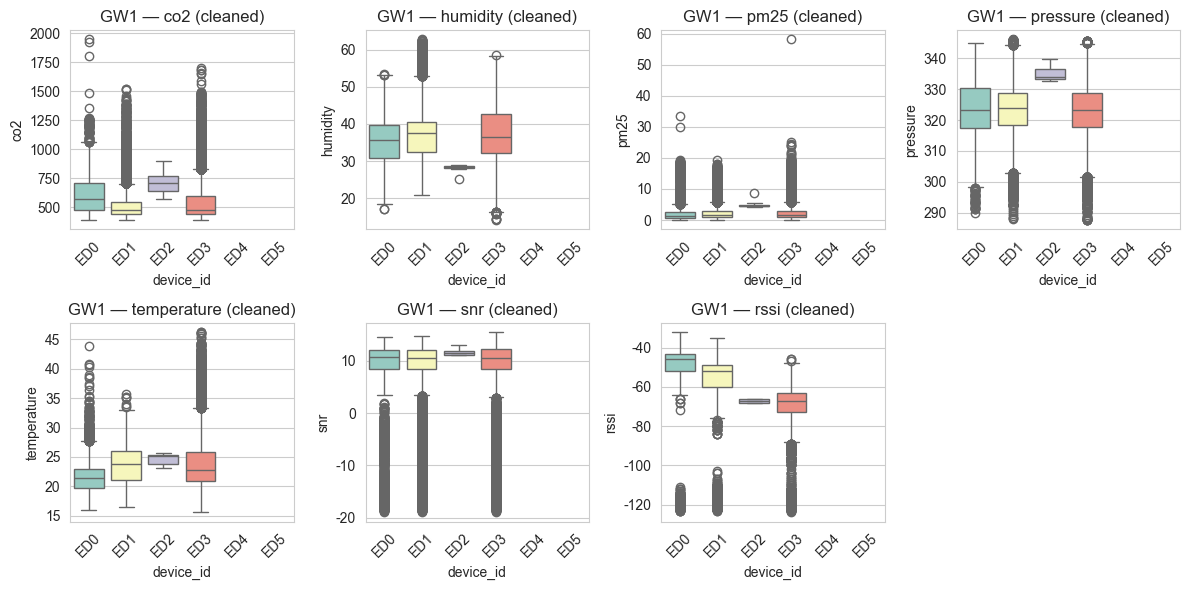

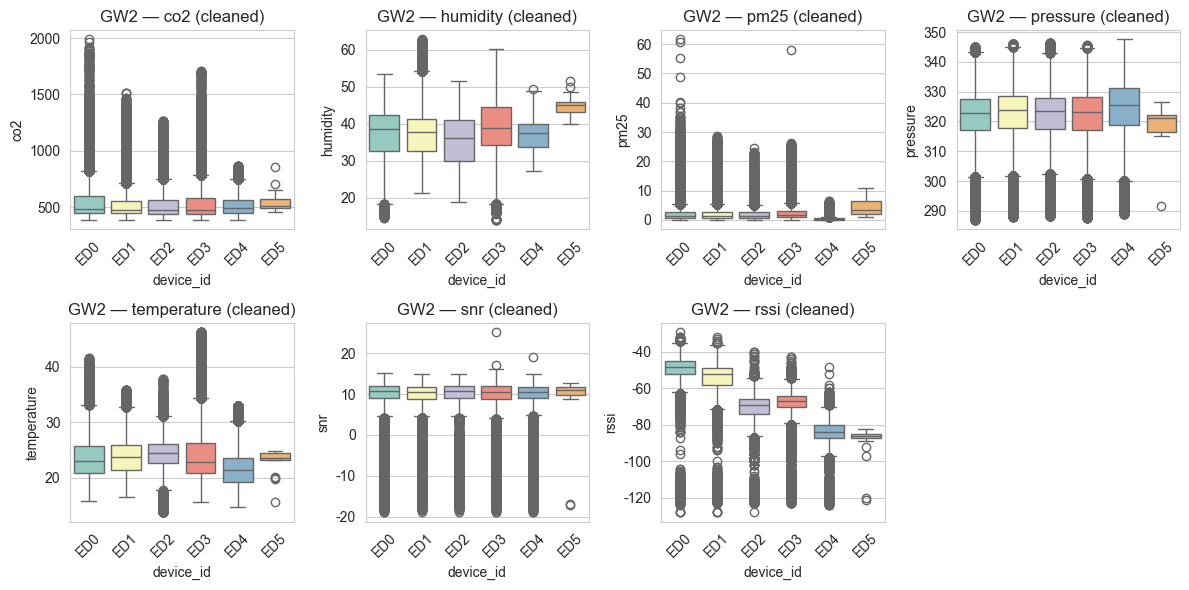

In [7]:
# Ensure we work on a copy to avoid SettingWithCopyWarning
plot_cols = ['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'snr', 'rssi']
plot_cols = [c for c in plot_cols if c in cleaned_data.columns]
order = [d for d in ["ED0","ED1","ED2","ED3","ED4","ED5"] if d in cleaned_data["device_id"].unique()]

cd = cleaned_data.copy()
cd.loc[:, "device_id"] = pd.Categorical(cd["device_id"], categories=order, ordered=True)

for gw in cd["gateway"].unique():
    gdf = cd[cd["gateway"] == gw]
    cols = 4
    rows = math.ceil(len(plot_cols) / cols)
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, col in enumerate(plot_cols, 1):
        plt.subplot(rows, cols, i)
        sns.boxplot(data=gdf, x="device_id", y=col,
                    hue="device_id", order=order, palette="Set3", dodge=False, legend=False)
        plt.title(f"{gw} — {col} (cleaned)")
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Final selection, info
</p>

In [8]:
# === Final Selection ===
columns_to_retain = [
    "time", "gateway", "device_id", "co2", "humidity", "pm25", "pressure", "temperature", 
    "rssi", "snr", "SF", "frequency", "f_count", "p_count", "toa", "distance_gw0", 
    "c_walls_gw0", "w_walls_gw0", "exp_pl_gw0", "n_power", "esp"
]
columns_to_retain = [c for c in columns_to_retain if c in cleaned_data.columns]
cleaned_data = cleaned_data[columns_to_retain].sort_values("time").reset_index(drop=True)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3411800 entries, 0 to 3411799
Data columns (total 21 columns):
 #   Column        Dtype              
---  ------        -----              
 0   time          datetime64[ns, UTC]
 1   gateway       object             
 2   device_id     category           
 3   co2           float64            
 4   humidity      float64            
 5   pm25          float64            
 6   pressure      float64            
 7   temperature   float64            
 8   rssi          float64            
 9   snr           float64            
 10  SF            int64              
 11  frequency     float64            
 12  f_count       float64            
 13  p_count       float64            
 14  toa           float64            
 15  distance_gw0  float64            
 16  c_walls_gw0   float64            
 17  w_walls_gw0   float64            
 18  exp_pl_gw0    float64            
 19  n_power       float64            
 20  esp           float64   

In [9]:
# === Save the cleaned data===
cleaned_data.to_csv(OUTPUT_PATH, index=False)
print(f"Saved to {OUTPUT_PATH}")
cleaned_data

Saved to ../LoRaWAN Localization - Advanced Files/all3_gateways_cleaned_dataset_per_device.csv


,time,gateway,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance_gw0,c_walls_gw0,w_walls_gw0,exp_pl_gw0,n_power,esp
0,2024-10-01 00:01:07.420593+00:00,GW0,ED5,440.0,45.46,0.46,313.80,22.41,-102.0,10.2,9,868.1,9868.0,10756.0,0.246784,40.0,2.0,2.0,119.26,-112.596121,-102.396121
1,2024-10-01 00:01:25.764905+00:00,GW2,ED2,451.0,40.59,0.43,314.81,22.83,-66.0,11.0,10,867.9,5815.0,6642.0,0.452608,NaN,NaN,NaN,NaN,-77.331956,-66.331956
2,2024-10-01 00:01:25.764905+00:00,GW0,ED2,451.0,40.59,0.43,314.81,22.83,-66.0,11.0,10,867.9,5815.0,6642.0,0.452608,23.0,0.0,2.0,83.26,-77.331956,-66.331956
3,2024-10-01 00:01:50.313519+00:00,GW2,ED4,435.0,37.33,0.05,315.54,24.06,-119.0,-1.8,10,867.1,9335.0,10753.0,0.452608,NaN,NaN,NaN,NaN,-121.202895,-123.002895
4,2024-10-01 00:01:50.313519+00:00,GW0,ED4,435.0,37.33,0.05,315.54,24.06,-119.0,-1.8,10,867.1,9335.0,10753.0,0.452608,37.0,0.0,5.0,136.26,-121.202895,-123.002895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411795,2025-09-30 23:59:51.442628+00:00,GW0,ED3,725.0,48.96,1.91,331.95,20.43,-60.0,12.2,8,867.9,117189.0,117586.0,0.133632,18.0,1.0,2.0,77.26,-72.454107,-60.254107
3411796,2025-09-30 23:59:51.442628+00:00,GW2,ED3,725.0,48.96,1.91,331.95,20.43,-60.0,12.2,8,867.9,117189.0,117586.0,0.133632,NaN,NaN,NaN,NaN,-72.454107,-60.254107
3411797,2025-09-30 23:59:54.616737+00:00,GW0,ED5,493.0,46.30,3.16,331.90,22.49,-94.0,10.8,9,868.3,127147.0,127514.0,0.246784,40.0,2.0,2.0,111.26,-105.146992,-94.346992
3411798,2025-09-30 23:59:55.971870+00:00,GW0,ED2,780.0,38.50,1.19,332.47,25.46,-68.0,7.8,7,868.5,127238.0,127523.0,0.071936,23.0,0.0,2.0,85.26,-76.466832,-68.666832
